In [4]:
from sklearn.datasets import make_classification

from spectral_binaries.train import run_RF
from spectral_binaries.visualization import (
    plot_feature_importance,
    plot_confusion_matrix,
    plot_roc,
    plot_prc,
    plot_calibration
)

X, y = make_classification(n_samples=10000, n_features=20, n_redundant=0, n_clusters_per_class=1, random_state=0)
results = run_RF(X, y, calibration_method="isotonic")
results
# plot_confusion_matrix(y_test, y_pred, classes=data.target_names, file_name="test_cm.pdf", title="Test Confusion Matrix")
# plot_feature_importance(clf, np.array(data.feature_names), file_name="test_fi.pdf")
# plot_roc(clf, X_test, y_test, file_name="test_roc.pdf")
# plot_prc(clf, X_test, y_test, file_name="test_prc.pdf")

Running grid search on training set...
Best parameters found:  {'min_samples_split': 5}

Brier score loss before calibration: 0.05826869017312961
Brier score loss after calibration: 0.05643137704336232 

Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       981
           1       0.95      0.91      0.93      1019

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



{'model': CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                              min_samples_split=5,
                                                              n_jobs=-1),
                        method='isotonic'),
 'X_test':             0         1         2         3         4         5         6   \
 0    -0.510144  0.078188  2.328888 -1.032410 -2.245191  0.394154 -0.491724   
 1    -1.416633 -0.225771  1.902388  1.867866  0.268068  1.500185 -0.053727   
 2     0.616242 -2.014719  0.710532 -0.169571  2.700114  1.076344  0.650592   
 3    -0.839976  0.583591  1.079528  0.483236 -1.720945 -1.366262  0.631784   
 4    -1.232808 -0.827980  0.828837  0.046391  0.663718 -0.800999 -1.058624   
 ...        ...       ...       ...       ...       ...       ...       ...   
 1995  2.477150  1.077498  2.335623  0.494694 -0.461719  0.580784  2.158404   
 1996  0.172706  0.027445  1.700825  1.705746  0.160949  0.26

**IMPORTANT**: DO NOT run cross-validation again for evaluating the final model you get from the function. It was already run for model selection, and running it again on a final model can produce and overestimation of the true performance.

### Calibration Plots
Calibration plots are a valuable tool for evaluating the performance of binary classification models, especially when predicting probabilities. In a binary classification problem, the model must predict whether a given instance belongs to one of two possible classes. However, in addition to simply making a prediction for each instance, many classification algorithms also provide a probability estimate of how likely the instance is to belong to each class.

Calibration plots help us evaluate whether the predicted probabilities from a binary classification model are accurate. Specifically, a calibration plot compares the *predicted probabilities to the actual observed frequencies of each class*, across a range of predicted probabilities. In a well-calibrated model, the predicted probabilities should be close to the observed frequencies, which indicates that the model's probability estimates are reliable.

*Why should we care about accurate probabilities?* The model's predicted probabilities provide insight into the model's overall performance and reliability of its predictions. For example, let's say a binary classification model is being used to predict whether a patient has a certain medical condition. The model produces a probability estimate for each patient, indicating the likelihood of having the condition. If the model's predicted probabilities are well-calibrated, a high probability estimate indicates that the patient is more likely to have the condition, and a low probability estimate indicates that the patient is less likely to have it.

On the other hand, if the model's predicted probabilities are not well-calibrated, a high probability estimate may not accurately reflect the truth likelihood of the patient having the condition, leading to incorrect decisions are actions. The model may produce high probability estimates for patients who do not have the condition, leading to unnecessary testing or treatment.

To create a calibration plot, we first divide the range of predicted probabilities into several "bins" or intervals. The actual observed frequencies of each class are then calculated for each bin. Then, we calculate and plot the average predicted probability for each bin A well-calibrated model will produce a calibration plot where the *points fall close to the diagonal line*, indicating that the predicted probabilities are close to the observed frequencies.

*Why is all of this useful?* First, it allows us to assess the reliability of the model's probability estimates. Second, it can help us identify and correct systematic biases in the model's predictions. Finally, we can use it to compare the calibration of different models, helping us select the best model for our task.

In [2]:
print(plot_calibration.__doc__)

Plot a calibration plot of the fitted model on the test data.

    Parameters
    ----------
    model : RandomForestClassifier
        Model fitted on templates.
    X_test : Union[np.ndarray, pd.DataFrame]
        DataFrame or 2D array of testing features.
    y_test: Iterable[int]
        Test ground truth labels.
    num_bins : int
        Number of bins for the calibration plot. 6 by default.
    strategy: str
        Binning strategy, either uniform or quantile. Uniform by default.
    file_name : str, optional
        File name for saving the calibration plot.

    Returns
    -------
    None
    


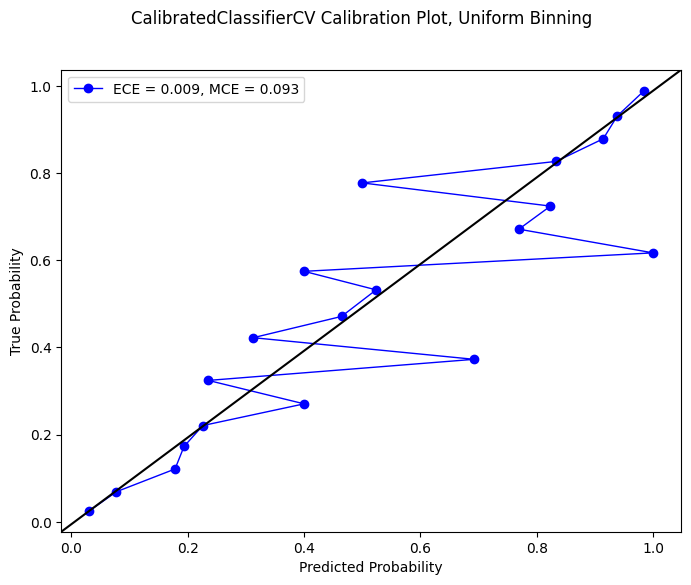

In [2]:
plot_calibration(results["model"], results["X_test"], results["y_test"], 20)

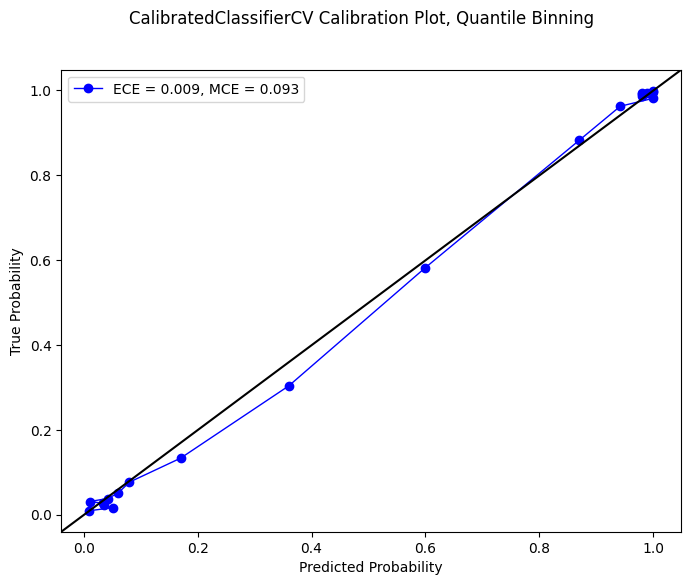

In [3]:
plot_calibration(results["model"], results["X_test"], results["y_test"], 20, strategy="quantile")

As we can see, the model appears better calibrated when we adjust for sample size, using the `quantile` binning strategy.

#### Choosing the Number of Bins

Choosing the appropriate number of bins requires a trade-off between the granularity of the plot and the number of examples in each bin. There are some guidelines and heuristics that can be used as a starting point for choosing the number of bins.
1. **Use a minimum of 10-15 bins.** Using fewer can result in a too coarse or smooth calibration plot.
2. **Use a maximum of 20-30 bins.** Using more can result in a too granular calibration plot that may not be visually interpretable, and may lead to overfitting or instability of the calibration measurements due to small sample sizes in each bin.
3. **Use a uniform or quantile-based binning.** Uniform binning involves diving the range of predicted probabilities into equally spaced intervals, while quantile-based binning involves dividing the range of predicted probabilities into intervals that contain roughly the same number of examples. Quantile-based binning can be more robust to outliers and skewed distributions, but may result in unevenly sized bins. You can pass in either a `uniform` or `quantile` strategy into `plot_calibration`. `uniform` is used by default.
4. **Consider the sample size in each bin.** Ideally, each bin should contain a sufficient number of examples to ensure reliable calibration measurements. A commonly used heuristic is to require at least 5-10 examples in each bin, although this may vary depending on the size of the dataset and the variability of predicted probabilities.
5. **Experiment with different binning schemes.** It is a generally good idea to experiment with different binning schemes and evaluate the resulting calibration plots using metrics such as Expected Calibration Error (ECE) or the Maximum Calibration Error (MCE). This can help identify the optimal number and type of bins for a given dataset model.

#### ECE and MCE

- The **Expected Calibration Error (ECE)** is a measure of the difference between the predicted probabilities and the true probabilities of the positive class, averaged over all bins of predicted probabilities. It is computed as the weighted average of the absolute difference between the average predicted probability and the true frequency of the positive class and each been, where the weights are the proportion of data points in each bin.
- The **Maximum Calibration Error (MCE)** is simply the maximum absolute difference between the predicted probabilities and the true probabilities in any bin.

#### Calibrating a Model

Here are some common methods to calibrate the model.

1. **Platt scaling:** Fit a logistic regression model to the predicted outputs of the original model on a validation set, where the target variable is the true binary class label. The logistic regression model can then be used to map the original outputs to calibrated probabilities.
2. **Isotonic regression:** Fit a non-parametric model to the predicted outputs of the original model on a validation set. The non-parametric model fits a monotonically increasing function to the outputs, such that the mapping from predicted outputs to calibrated probabilities is also monotonically increasing.
3. **Temperature scaling:** Scale the logits (unnormalized log probabilities) of the original model by a learnable scalar parameter called the temperature, which controls the confidence of the model's predictions. The temperature can be learned on a validation set using maximum likelihood estimation, by minimizing the negative log likelihood of the true binary class labels.

You can calibrate the model by passing in either `sigmoid` (Platt) or `isotonic` to the `calibration_method` argument of `run_RF`. This is optional!